In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from pathlib import Path

In [4]:
path = Path('data/')
path.ls()

[PosixPath('data/sat'), PosixPath('data/road')]

In [5]:
path_lbl = path/'road'
path_img = path/'sat'

In [6]:
from PIL import Image

In [7]:
import cv2
import numpy as np

def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [8]:
def convert_to_mask(fpath, thres=10):
    im = read_image(fpath)
    immsk = 1 * (im > 10)
    immsk = Image.fromarray(immsk[:,:,0].astype(np.uint8))
    immsk.save(fpath)
    return None

In [9]:
for fpath in list((path/'road').iterdir()):
    convert_to_mask(str(fpath))

## Data

In [10]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/sat/235_napa_sat.png'),
 PosixPath('data/sat/268_napa_sat.png'),
 PosixPath('data/sat/102_sf_sat.png')]

In [11]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/road/97_napa_road.png'),
 PosixPath('data/road/94_napa_road.png'),
 PosixPath('data/road/196_napa_road.png')]

In [12]:
len(lbl_names)

446

torch.Size([3, 512, 512])


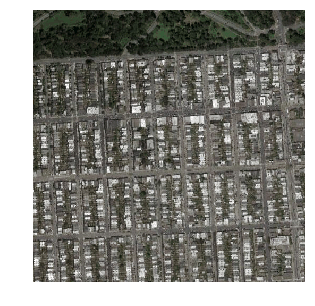

In [13]:
img_f = fnames[100]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(5,5))

poor choice of naming

In [14]:
get_y_fn = lambda x: Path('/'.join(['data', 'road'] + ['_'.join(str(x).split('/')[-1].split('_')[:-1] + ['road.png'])]))

In [15]:
get_y_fn(img_f)

PosixPath('data/road/29_sf_road.png')

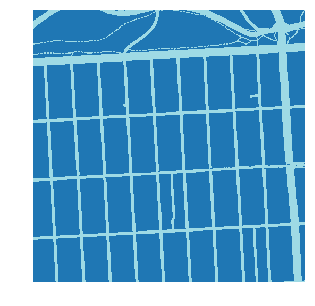

In [16]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [17]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([512, 512]), tensor([[[0, 0, 0,  ..., 0, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1]]]))

Need to find out all the codes present

## Datasets

In [27]:
#!ls sat/ | shuf -n 47 > test.txt

In [18]:
size = src_size//2
bs = 8

In [19]:
codes = np.array(['not-road', 'road'])

Randomly selecting some data for testing and writing the name into a file

In [20]:
!cat data/test.txt

125_napa_sat.png
65_sf_sat.png
45_napa_sat.png
73_napa_sat.png
14_sf_sat.png
3_napa_sat.png
19_sf_sat.png
16_napa_sat.png
281_napa_sat.png
125_sf_sat.png
68_sf_sat.png
183_napa_sat.png
93_napa_sat.png
67_sf_sat.png
110_sf_sat.png
163_napa_sat.png
56_napa_sat.png
179_napa_sat.png
79_napa_sat.png
31_napa_sat.png
114_sf_sat.png
175_napa_sat.png
284_napa_sat.png
137_sf_sat.png
78_napa_sat.png
68_napa_sat.png
275_napa_sat.png
261_napa_sat.png
273_napa_sat.png
133_sf_sat.png
12_sf_sat.png
26_napa_sat.png
193_napa_sat.png
13_sf_sat.png
200_napa_sat.png
294_napa_sat.png
82_napa_sat.png
33_sf_sat.png
269_napa_sat.png
23_napa_sat.png
25_napa_sat.png
145_napa_sat.png
55_sf_sat.png
95_napa_sat.png
77_napa_sat.png
169_napa_sat.png


In [21]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../test.txt')
       .label_from_func(get_y_fn, classes=codes))

In [22]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

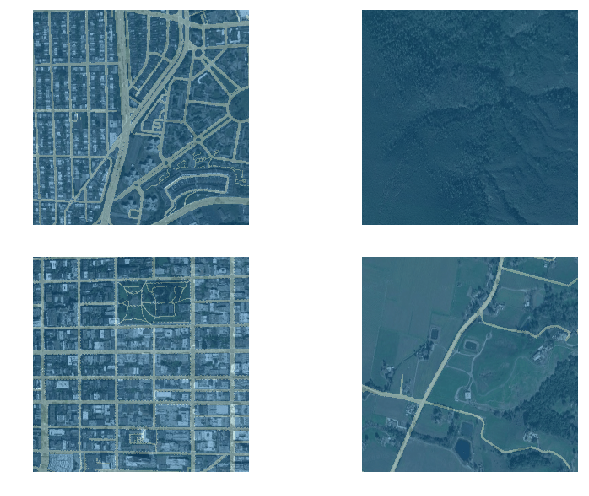

In [23]:
data.show_batch(2, figsize=(10,7))

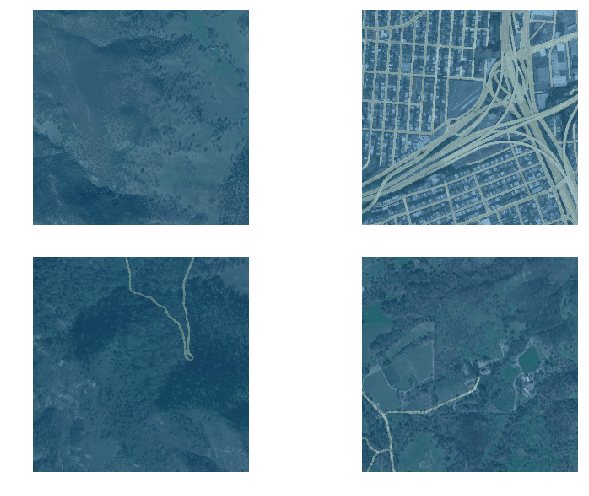

In [24]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [27]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_map(input, target):
    target = target.squeeze(1)
    # mask = target >= 2
    return (input.argmax(dim=1)==target).float().mean()

In [28]:
metrics=acc_map
# metrics=accuracy

In [29]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


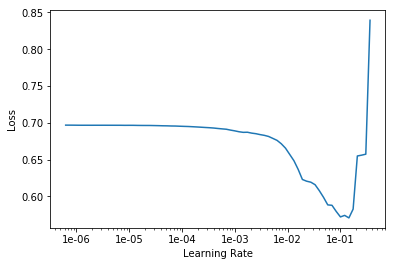

In [30]:
lr_find(learn)
learn.recorder.plot()

In [31]:
lr=1e-3

In [32]:
learn.fit_one_cycle(10, slice(lr))

Total time: 01:27
epoch  train_loss  valid_loss  acc_map 
1      0.669973    0.585300    0.904908  (00:10)
2      0.588931    0.522838    0.890477  (00:08)
3      0.349168    0.141685    0.947924  (00:08)
4      0.221632    0.120442    0.952044  (00:08)
5      0.167701    0.120081    0.949395  (00:08)
6      0.146784    0.104398    0.959002  (00:08)
7      0.135183    0.108719    0.954825  (00:08)
8      0.129720    0.100136    0.960455  (00:08)
9      0.125304    0.098792    0.960872  (00:08)
10     0.123091    0.097922    0.961396  (00:08)



In [33]:
learn.save('stage-1')

In [34]:
learn.load('stage-1');

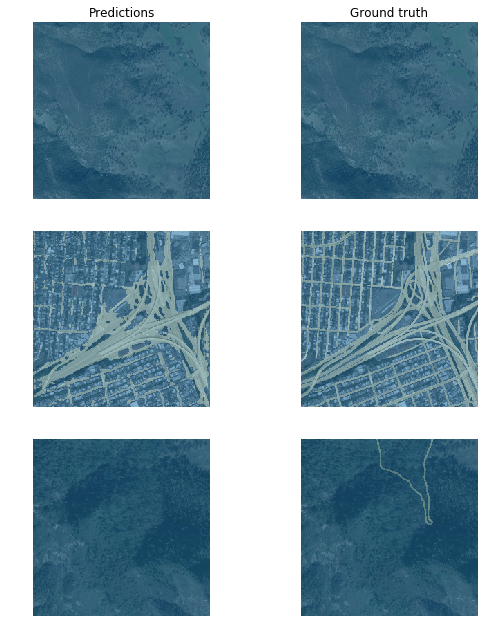

In [35]:
learn.show_results()

In [36]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


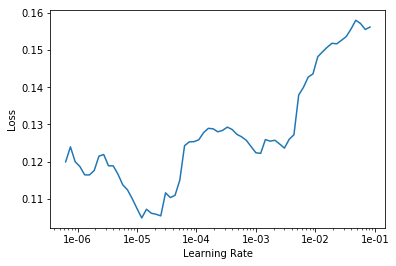

In [37]:
lr_find(learn)
learn.recorder.plot()

In [38]:
lrs = slice(1e-5,lr/5)

In [39]:
learn.fit_one_cycle(12, lrs)

Total time: 02:02
epoch  train_loss  valid_loss  acc_map 
1      0.119909    0.097296    0.961795  (00:10)
2      0.122073    0.098353    0.961463  (00:10)
3      0.121901    0.097409    0.961932  (00:10)
4      0.120749    0.095739    0.962883  (00:10)
5      0.120374    0.097256    0.962299  (00:10)
6      0.117312    0.095072    0.963093  (00:10)
7      0.116187    0.094894    0.962749  (00:10)
8      0.114033    0.093999    0.963598  (00:10)
9      0.111940    0.094057    0.963329  (00:10)
10     0.112868    0.093085    0.963772  (00:10)
11     0.111507    0.093374    0.963684  (00:10)
12     0.109137    0.092856    0.963928  (00:10)



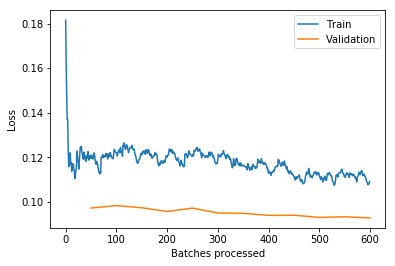

In [40]:
learn.recorder.plot_losses()

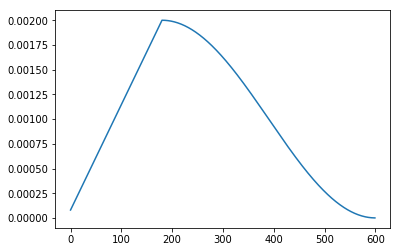

In [44]:
learn.recorder.plot_lr()

In [41]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [42]:
size = src_size
bs=4

In [43]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [44]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [45]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


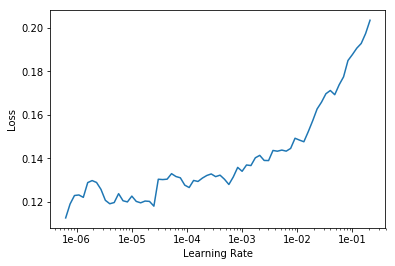

In [46]:
lr_find(learn)
learn.recorder.plot()

In [51]:
lr=1e-4

In [52]:
learn.fit_one_cycle(10, slice(lr))

Total time: 04:32
epoch  train_loss  valid_loss  acc_camvid
1      0.143098    0.114704    0.956114    (00:39)
2      0.124501    0.110868    0.957577    (00:25)
3      0.121624    0.108347    0.958276    (00:25)
4      0.125771    0.104573    0.960370    (00:25)
5      0.129221    0.105436    0.959890    (00:26)
6      0.117407    0.105183    0.960171    (00:25)
7      0.124600    0.104942    0.960042    (00:25)
8      0.119045    0.103447    0.960780    (00:25)
9      0.112703    0.103815    0.960596    (00:25)
10     0.116333    0.105237    0.959928    (00:25)



In [47]:
learn.save('stage-1-big')

In [53]:
learn.load('stage-1-big');

In [49]:
learn.unfreeze()

In [50]:
lrs = slice(1e-6,lr)

In [52]:
#learn.fit_one_cycle(10, lrs, wd=1e-3)

In [58]:
learn.save('stage-2-big')

In [54]:
#learn.load('stage-2-big')

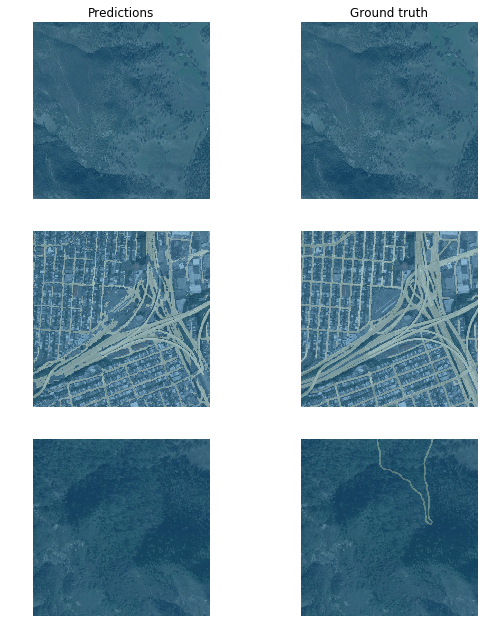

In [55]:
learn.show_results()